In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
#Importing GaussianMixture to use its built-in BIC function.
from sklearn.mixture import GaussianMixture

In [31]:
#dfelectricalUsage = pd.read_csv("daily_electricity_usage 2.csv",parse_dates=thedate)
#dfelectricalUsage.count()

dfElectricalUsage = pd.read_csv('daily_electricity_usage.csv', index_col=1, parse_dates=True)
len(dfElectricalUsage)


3291258

## Cleaning data

In [3]:
min_date = dfElectricalUsage.index.min() 
max_date = dfElectricalUsage.index.max()

period = pd.date_range(min_date, max_date) #Date range from first to last date.
meter_ids = dfElectricalUsage['Meter ID'].unique() #Getting the meter ids.

for meter_id in meter_ids:
    if len(dfElectricalUsage[dfElectricalUsage['Meter ID'] == meter_id]) == 536: #If a meter id has all the dates, we skip it.
        continue
        
    #print(meter_id) #Printing meter ids that need to be filled.
    
    ind = dfElectricalUsage['Meter ID'] == meter_id
    dfElectricalUsage[ind] = dfElectricalUsage[ind].loc[period]
    
    #First fill meter ids. Using ffill AND bfill in case first or last date is missing.
    dfElectricalUsage[ind]['Meter ID'] = dfElectricalUsage[ind]['Meter ID'].ffill().bfill()
    #Filling the missing values with the mean.    
    dfElectricalUsage[ind]['total daily KW'].fillna(dfElectricalUsage[ind].mean()[1], inplace = True)

/Users/alexanthony/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/Users/alexanthony/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/alexanthony/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

In [4]:
#print(dfelectricalUsage.head())  
#setting date column as index column for better lookupolloøopøløolopoplpø--

#print(dfelectricalUsage.tail())
#print(dfelectricalUsage.count())
#print(dfelectricalUsage.dtypes)

In [5]:
#dfelectricalUsage.drop_duplicates()   -- there are no duplicates

In [6]:
df = dfElectricalUsage.groupby('Meter ID').nunique()
print("Total # of cunsumers", df.count())

Total # of cunsumers Meter ID          6435
total daily KW    6435
dtype: int64


## Adding calender features to dataset ##

In [7]:
from datetime import date
import calendar
my_date = date.today()
calendar.day_name[my_date.weekday()]

'Friday'

In [8]:
column_1 = dfElectricalUsage.iloc[:,0]
column_1
#Tried using next line since index_col was changed to 'date'.
#column_1 = dfElectricalUsage.reset_index().set_index('Meter ID').iloc[:,0]
dfElectricalUsage

dfElectricalUsage = pd.DataFrame({"date":dfElectricalUsage.index,
                               "year": dfElectricalUsage.index.year,
                               "month": dfElectricalUsage.index.month,
                               "day": dfElectricalUsage.index.day,
                               "dayofyear": dfElectricalUsage.index.dayofyear,
                               "weekofyear": dfElectricalUsage.index.weekofyear,
                               "weekday": dfElectricalUsage.index.weekday,
                               "quarter": dfElectricalUsage.index.quarter,
                               "DailyUsage": dfElectricalUsage['total daily KW'],
                               "Meter ID": dfElectricalUsage['Meter ID']})

print(dfElectricalUsage.head())

                 date  year  month  day  dayofyear  weekofyear  weekday  \
date                                                                      
2009-07-14 2009-07-14  2009      7   14        195          29        1   
2009-07-15 2009-07-15  2009      7   15        196          29        2   
2009-07-16 2009-07-16  2009      7   16        197          29        3   
2009-07-17 2009-07-17  2009      7   17        198          29        4   
2009-07-18 2009-07-18  2009      7   18        199          29        5   

            quarter  DailyUsage  Meter ID  
date                                       
2009-07-14        3      11.203    1000.0  
2009-07-15        3       8.403    1000.0  
2009-07-16        3       7.225    1000.0  
2009-07-17        3      11.338    1000.0  
2009-07-18        3      11.306    1000.0  


In [9]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
holidays = cal.holidays(start='2009-07-14', end='2010-10-17')
dfElectricalUsage['Holiday'] = dfElectricalUsage.index.isin(holidays)
dfElectricalUsageOnlyHoliday = dfElectricalUsage[dfElectricalUsage['Holiday']== True]
print(dfElectricalUsageOnlyHoliday)

                 date  year  month  day  dayofyear  weekofyear  weekday  \
date                                                                      
2009-09-07 2009-09-07  2009      9    7        250          37        0   
2009-10-12 2009-10-12  2009     10   12        285          42        0   
2009-11-11 2009-11-11  2009     11   11        315          46        2   
2009-11-26 2009-11-26  2009     11   26        330          48        3   
2009-12-25 2009-12-25  2009     12   25        359          52        4   
2010-01-01 2010-01-01  2010      1    1          1          53        4   
2010-01-18 2010-01-18  2010      1   18         18           3        0   
2010-02-15 2010-02-15  2010      2   15         46           7        0   
2010-05-31 2010-05-31  2010      5   31        151          22        0   
2010-07-05 2010-07-05  2010      7    5        186          27        0   
2010-09-06 2010-09-06  2010      9    6        249          36        0   
2010-10-11 2010-10-11  20

**Segementation code** 

In [10]:
#daily Average per user
dfElectricalUsage.head()
dfUserGroup = dfElectricalUsage.groupby('Meter ID')['DailyUsage'].mean().reset_index(name='DailyAvgPerUser')

#Quarterly Average per user
qtly_avg_cols = ['Meter ID', 'Q1Avg', 'Q2Avg', 'Q3Avg', 'Q4Avg']
dfUserGroup2 = dfElectricalUsage.groupby(['Meter ID','quarter'])['DailyUsage'].mean().reset_index(name='qtlylyAvg')
dfUserGroup2 = dfUserGroup2.pivot(index = 'Meter ID', columns = 'quarter')['qtlylyAvg'].reset_index()
dfUserGroup2.columns = qtly_avg_cols

# Weekday Average per user
weekday_avg_cols = ['Meter ID', 'MonAvg', 'TueAvg', 'WedAvg', 'ThursAvg','FriAvg','SatAvg','SunAvg']
dfUserGroup3 = dfElectricalUsage.groupby(['Meter ID','weekday'])['DailyUsage'].mean().reset_index(name='weekdayAvg')
dfUserGroup3 = dfUserGroup3.pivot(index = 'Meter ID', columns = 'weekday')['weekdayAvg'].reset_index()
dfUserGroup3.columns = weekday_avg_cols
#Monthly average per user
month_avg_cols = ['Meter ID', 'janAvg', 'febAvg', 'marAvg', 'aprAvg', 'mayAvg', 'junAvg', 'julAvg', 'augAvg', 'sepAvg', 'octAvg', 'novAvg', 'desAvg']
dfUserGroup4 = dfElectricalUsage.groupby(['Meter ID', 'month'])['DailyUsage'].mean().reset_index(name='monthlyAverage')
dfUserGroup4 = dfUserGroup4.pivot(index = 'Meter ID', columns = 'month')['monthlyAverage'].reset_index()
dfUserGroup4.columns = month_avg_cols



# Merging groups to one dataframe
dfElectricityUsage1 = pd.merge(dfUserGroup,dfUserGroup2,on='Meter ID')
dfElectricityUsage2 = pd.merge(dfElectricityUsage1,dfUserGroup3,on='Meter ID')
dfElectricityUsage = pd.merge(dfElectricityUsage2,dfUserGroup4,on='Meter ID')
dfElectricityUsage


,Meter ID,DailyAvgPerUser,Q1Avg,Q2Avg,Q3Avg,Q4Avg,MonAvg,TueAvg,WedAvg,ThursAvg,...,marAvg,aprAvg,mayAvg,junAvg,julAvg,augAvg,sepAvg,octAvg,novAvg,desAvg
0,1000.0,10.290438,12.184656,7.886923,8.704567,12.026440,10.029066,10.493675,10.596247,9.203974,...,9.584774,8.411233,7.646516,7.611033,8.431796,8.774016,8.855567,10.584613,11.252267,14.217468
1,1001.0,9.496968,6.740656,4.393681,5.030871,17.519630,9.461461,9.494429,9.446922,9.659545,...,7.799903,5.030867,4.091355,4.068900,5.050061,4.959355,5.089100,5.178452,11.673000,35.518839
2,1002.0,9.986623,11.041756,9.663022,9.457491,10.122315,11.068092,10.070377,11.133766,10.555091,...,9.970290,8.100100,10.225839,10.644367,9.943857,9.244500,9.280383,8.675387,11.422967,10.310548
3,1003.0,30.420860,34.442156,29.878198,26.478684,32.385957,31.205987,29.749117,30.104987,30.415584,...,33.922000,32.629533,32.622774,24.290800,26.464633,25.851242,27.138517,29.507403,32.247150,35.398839
4,1004.0,47.250825,45.986500,41.709725,48.071123,49.847337,48.756053,46.630390,47.364740,44.976065,...,42.683742,37.611300,45.338000,42.058933,45.918694,47.645984,50.268250,48.738435,49.455483,51.335452
5,1005.0,29.968106,39.393122,22.774330,22.066216,36.259440,29.647855,30.446221,30.518545,28.193481,...,35.759097,21.622033,23.676968,22.993900,22.216592,20.610516,23.447633,27.614290,37.748383,43.463677
6,1006.0,21.490522,29.277178,12.955681,15.665778,27.316082,22.084829,21.356779,20.089506,21.061727,...,22.639581,17.202033,15.096097,6.497567,14.505694,15.255452,17.037183,21.187419,25.486700,35.215113
7,1007.0,34.972277,39.328789,35.156824,31.545749,35.939798,33.781329,32.209870,33.279325,33.268987,...,40.883000,33.964867,34.925968,36.587333,28.262041,34.448919,31.227500,31.855887,36.185800,39.848689
8,1008.0,35.155172,41.770378,30.745473,28.936544,39.905443,34.853908,36.030545,34.398909,32.706974,...,38.629032,34.497233,29.669387,28.105667,28.417388,28.201677,30.119883,34.076661,38.891633,46.826967
9,1009.0,40.108558,41.688656,29.571176,37.983398,46.522120,37.402803,39.876870,39.290675,40.590494,...,34.730323,30.650067,28.860161,29.227000,34.060245,38.973952,40.163733,43.952226,46.779183,48.843242


**K-Means Clustering**


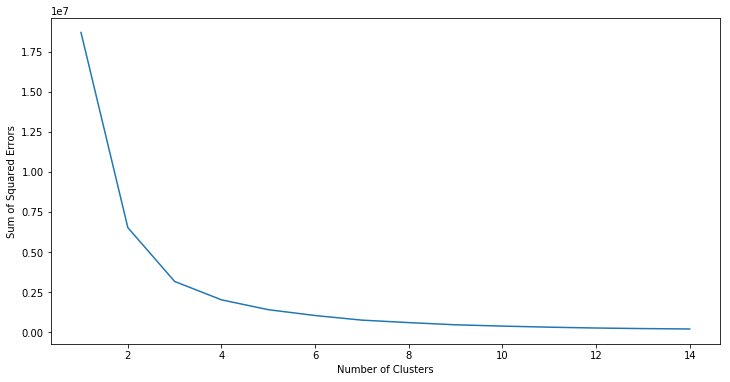

In [11]:
features = dfUserGroup.iloc[:, 1:]

SSE = {}
for k in range(1, 15):
    model = KMeans(n_clusters = k).fit(features)
    #features["clusters"] = model.labels_
    SSE[k] = model.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    
plt.figure(figsize = (12,6))
plt.plot(list(SSE.keys()), list(SSE.values()))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Errors")
plt.show()

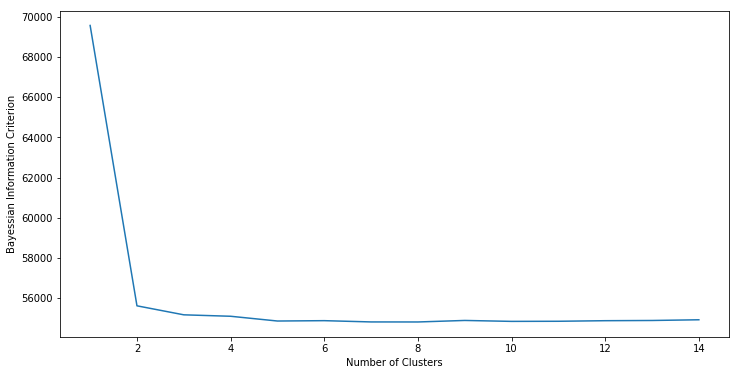

In [12]:
BIC = {}

for k in range(1, 15):
    model = GaussianMixture(n_components = k, init_params = 'kmeans').fit(features)
    BIC[k] = model.bic(features)

plt.figure(figsize = (12,6))
plt.plot(list(BIC.keys()), list(BIC.values()))
plt.xlabel("Number of Clusters")
plt.ylabel("Bayessian Information Criterion")
plt.show()

In [13]:
k_means = KMeans(n_clusters = 3).fit(features) #Using 3 clusters, change this after adding more features.
features['Cluster'] = k_means.fit_predict(features)
print(features.head())
features.Cluster.value_counts()


   DailyAvgPerUser  Cluster
0        10.290438        0
1         9.496968        0
2         9.986623        0
3        30.420860        0
4        47.250825        0


0    6155
1     242
2      38
Name: Cluster, dtype: int64

## FBProphet Time Series Prediction ##

In [14]:
# Adding cluster as a column to original dataset 
dfElectricityUsage['cluster']=features['Cluster']


#finding mean grouped by clsuter to show the variation of usage between clusters
print(dfElectricityUsage[dfElectricityUsage.columns[1:]].groupby(['cluster']).agg([np.mean]))


dfNew = dfElectricityUsage
dfElectricityUsage.set_index('Meter ID')
dfElectricityUsage.set_index('Meter ID')
# Merging our original dataset to the processed one , so that we get all features and cluster for the Meter ID
dfNew =dfElectricalUsage.merge(dfElectricityUsage , how ='inner')

#making seperate datagrame for each cluster
col_list = ['date','DailyUsage']
dfUserGroupClus1 = dfNew[(dfNew['cluster']==0)]
dfUserGroupClus1 = dfUserGroupClus1[col_list]
dfUserGroupClus1.columns=['ds','y']
dfUserGroupClus2 = dfNew[(dfNew['cluster']==1)]
dfUserGroupClus2 = dfUserGroupClus2[col_list]
dfUserGroupClus2.columns=['ds','y']
dfUserGroupClus3 = dfNew[(dfNew['cluster']==2)]
dfUserGroupClus3 = dfUserGroupClus3[col_list]
dfUserGroupClus3.columns=['ds','y']



        DailyAvgPerUser       Q1Avg       Q2Avg       Q3Avg       Q4Avg  \
                   mean        mean        mean        mean        mean   
cluster                                                                   
0             26.387294   29.834344   23.030308   23.114425   29.247357   
1            181.617309  215.505371  167.543677  163.073288  193.568368   
2            544.958598  546.173265  528.606750  546.495515  544.190667   

             MonAvg      TueAvg      WedAvg    ThursAvg      FriAvg  \
               mean        mean        mean        mean        mean   
cluster                                                               
0         26.419901   26.721536   26.497417   26.318221   26.276593   
1        189.549766  199.851312  199.490516  199.384684  196.371054   
2        550.889931  565.142717  567.232331  580.338284  574.894602   

            ...          marAvg      aprAvg      mayAvg      junAvg  \
            ...            mean        mean        

In [15]:
def plot_data(data_forc):
    timeseries=data_forc.copy()
    timeseries.columns=['date','Total Daily KW']
    timeseries = timeseries.set_index('date') 
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.scatter(timeseries.index,timeseries['Total Daily KW'],c='blue',s=2)

In [16]:
import fbprophet
from sklearn.metrics import mean_squared_error, r2_score


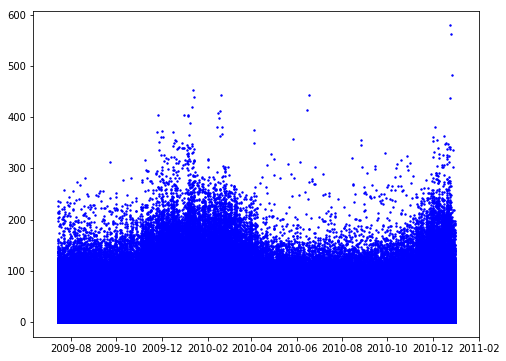

In [17]:
plot_data(dfUserGroupClus1)

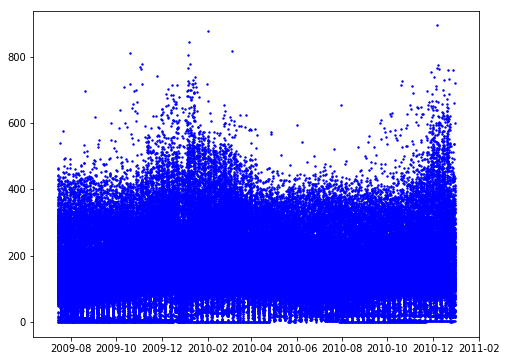

In [18]:
plot_data(dfUserGroupClus2)

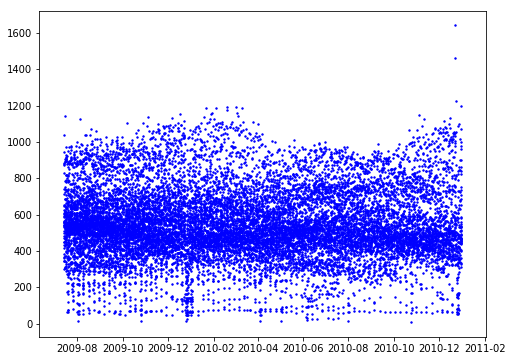

In [ ]:
plot_data(dfUserGroupClus3)

In [21]:
# Actual Prediction 
#train_0,test_0,predics_0,future_0,RMSE_0,R2_0=predic_fbp(dfUserGroupClus1,90)

In [22]:
model = fbprophet.Prophet(daily_seasonality=False,weekly_seasonality=True,
                yearly_seasonality=True,changepoint_prior_scale=0.05,changepoints=None,interval_width=0.95)

In [62]:
size = len(dfUserGroupClus2) - 30


In [63]:
train, test = dfUserGroupClus2[0:size], dfUserGroupClus2[size:]

In [64]:
test_=test.set_index('ds')

In [65]:
model.fit(train)

Exception: Prophet object can only be fit once. Instantiate a new object.

In [ ]:
predics=model.predict(dfUserGroupClus2)

In [45]:
test=pd.merge(test,predics[['ds','yhat','yhat_lower','yhat_upper']],how='left',on='ds')

In [46]:
 train=pd.merge(train,predics[['ds','yhat','yhat_lower','yhat_upper']],how='left',on='ds')
    

In [48]:
RMSE=np.sqrt(mean_squared_error(test['y'], test['yhat']))
print('RMSE = %.2f' % RMSE)

RMSE = 38.60


In [49]:
R2=r2_score(test['y'], test['yhat'])
print('R Square = %.2f'% R2)

R Square = -4.47


In [56]:
future = model.make_future_dataframe(periods=30, freq='D')

In [58]:
future=model.predict(future)

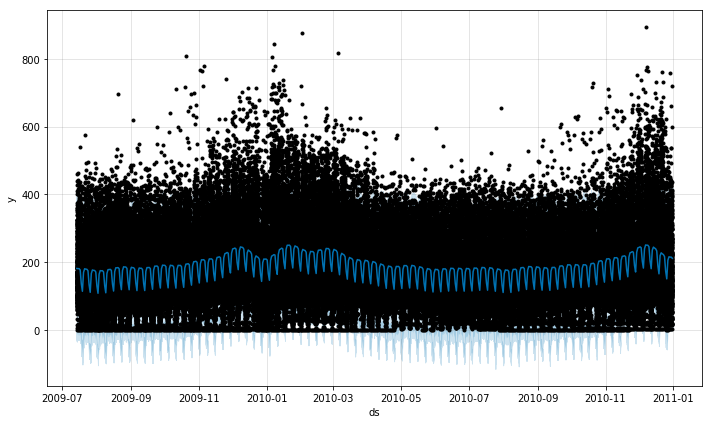

In [59]:
fig=model.plot(predics)

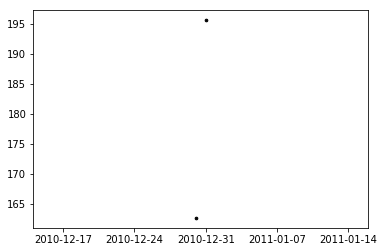

In [60]:
   plt.scatter(test_.index,test_['y'],c='black',s=7)
    

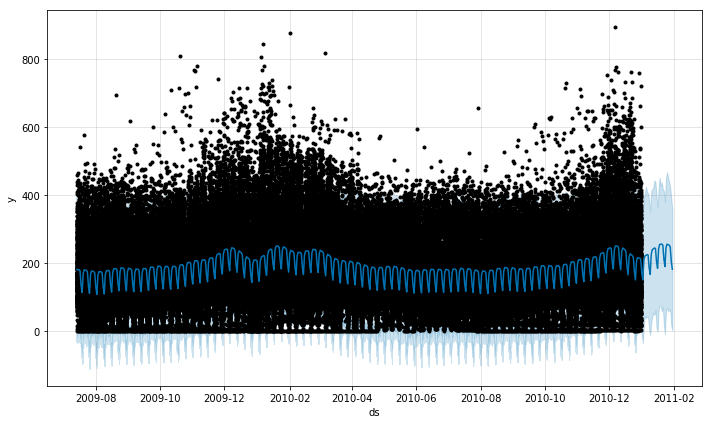

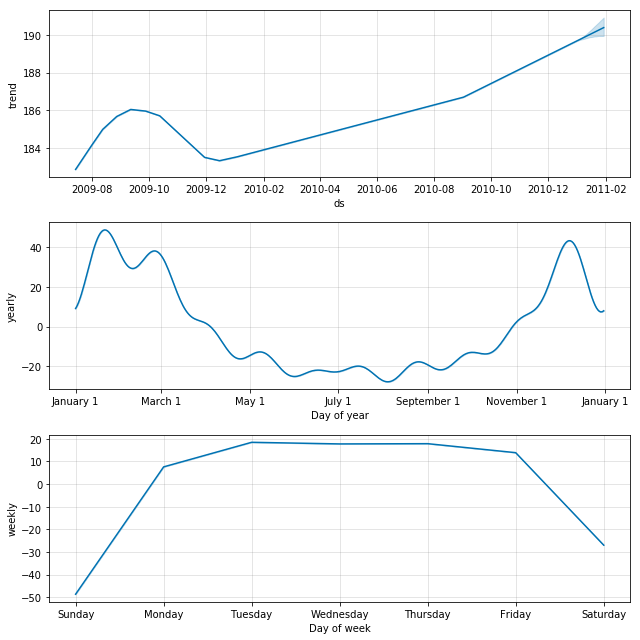

In [61]:
    fig2=model.plot(future)
    plt.scatter(test_.index,test_['y'],c='black',s=7)
    fig3=model.plot_components(future)